In [1]:
import sys
import pandas as pd
import numpy as np
import re
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords,wordnet
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import itertools


C:\Users\hyqro\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Part1: Webscraping

In [58]:
find_date = re.compile(r'<tr><td class="review-rating-header date_flown">Date Flown</td><td class="review-value">(.*)</td></tr>')
find_traveller_type = re.compile(r'<tr><td class="review-rating-header type_of_traveller">Type Of Traveller</td><td class="review-value">(.*)</td></tr>')
find_seat_class = re.compile(r'<tr><td class="review-rating-header cabin_flown">Seat Type</td><td class="review-value">(.*)</td></tr>')
find_review_content = re.compile(r'<div class="text_content" itemprop="reviewBody">(.*)</div>.*<div class="review-stats">',re.S)  
find_recommend = re.compile(r'<tr><td class="review-rating-header recommended">Recommended</td><td class="review-value rating-(.*)">')
find_general_score = re.compile(r'<span itemprop="ratingValue">(\d*?)</span>')

In [59]:
# get correspoding url
def askURL(url):
    head= {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.146 Safari/537.36'}
    page = requests.get(url,headers= head)
    return page

In [60]:
def getData():
    datalist=[]
    
    for i in range(0,1):    #20 reviews on each pages         
        url = 'https://www.airlinequality.com/airline-reviews/aerolineas-argentinas/page/{}/?sortby=post_date%3ADesc&pagesize=20'.format(str(i+1))
        html = askURL(url)            
        

        soup = BeautifulSoup(html.text, 'html.parser')          # Put the HTML document into memory 
        for item in soup.find_all('article',{'itemprop':'review'}):    #Find the string that meets the requirements to form a list

            item = str(item)                          
            
            #save the information of each review
            data=[]                                       
            

            flight_date = re.findall(find_date, item)[0]              
            data.append(flight_date)
            
            travel_type = re.findall(find_traveller_type,item)[0]
            data.append(travel_type)
            
            seat_class = re.findall(find_seat_class,item)[0]
            data.append(seat_class)
            
            review_content  = re.findall(find_review_content,item)[0]
            if r'/strong' in review_content:
                content = review_content.split(r'</strong>')[1]
                data.append(content)
            else: 
                data.append(review_content)
                
            recommend = re.findall(find_recommend,item)[0]
            data.append(recommend)
            
            general_score = re.findall(find_general_score,item)[0]
            data.append(general_score)
            
            
            datalist.append(data) 
        
    return datalist

In [61]:
#save data scrapped as xls file
def saveData(datalist):
    
    #create book and sheet
    book=xlwt.Workbook(encoding='utf-8')
    sheet = book.add_sheet('airline_review')
    
    #set the column names
    col = ('flight_date', 'travel_type', 'seat_class', 'review_content', 'recommend','general_score','airline')
    for i in range(0,7):
        sheet.write(0,i,col[i])
        
    #save the data
    for k in range(0,20):
        print('Writing %d th review now' % k)
        data = datalist[k]

        for v in range(0,6):
            sheet.write(k+1, v, data[v])
            
        sheet.write(k+1, 6, 'aerolineas-argentinas')
    book.save('C:/Users/Qiu Ziting/Desktop/aerolineas-argentinas.xls')

In [ ]:
#add label "polarity" by features "recommend" and "general score"
#seperate data into three classes:positive reviews ,negative reviews and vague attitude reviews 
data = pd.read_excel('C:/Users/Qiu Ziting/Desktop/Airline_review/Air_france.xls')
data['recommend'] = data['recommend'].apply(lambda x :x.split('"')[0])
def polarity(recommend, score):
    #negative
    if recommend =='no' and score <=4:
        return -1
    #positive
    if recommend =='yes' and score >=6:
        return 1
    
    #conflict
    if recommend =='yes' and score == 5:
        return 0
    if recommend =='no' and score == 5:
        return 0    
    if recommend =='no' and score >=6:
        return 0
    if recommend =='yes' and score <=4:
        return 0  
data['polarity']= data.apply(lambda x: polarity(x['recommend'],x['general_score']),axis=1)
data['airline'] = 'Air_France'
poutput_path = 'C:/Users/Qiu Ziting/Desktop/Air_France.csv'
data.to_csv(poutput_path,header=True, index=True)

# Part2:Emotion detection(TFIDF+Neural network)

### load reviews

In [2]:
def extract_content(file_name):
    for row in open(file_name, "r",encoding='utf-8',errors='ignore'):
        yield simple_preprocess(row.split('\t')[0], deacc=True)

In [3]:
def preprocessing(file_name):
    content = []
    for row in extract_content(file_name):
        content.append(row)
    content = [x for x in content if x!= []]    
    return content    

In [4]:
content1 = []
for project in tqdm(['pos_reviews']):
    file_name = "C:/Users/hyqro/Desktop/hackathon_2021/{}.csv".format(project)
    data = preprocessing(file_name)
    content1 += data

In [5]:
content2 = []
for project in tqdm(['neg_reviews']):
    file_name = "C:/Users/hyqro/Desktop/hackathon_2021/{}.csv".format(project)
    data = preprocessing(file_name)
    content2 += data

### Preprocessing

In [6]:
#load pre-trained word2vector model
from gensim.models import Word2Vec
model = Word2Vec.load('C:/Users/hyqro/Desktop/hackathon_2021/word2vec.model')

In [7]:
#load pre-trained tfidf vectorizer
import pickle 
vectorizer = pickle.load(open("C:/Users/hyqro/Desktop/hackathon_2021/vectorizer.pickle","rb"))
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [8]:
#concat word vectors to form vector for each review
def build_wordvector(tokens, size=200):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError:
                         
            continue
    if count != 0:
        vec /= count
    return vec.reshape(-1)

In [9]:
#scale dataset
from sklearn.preprocessing import scale
def  generate_dataset(content):
    content = content
    X_test = pd.Series(content)
    X_test_vector = X_test.apply(lambda x: build_wordvector(x))
    X_test_vector = np.array(X_test_vector.tolist())
    X_test_vector = scale(X_test_vector)
    return X_test_vector

### Positive reviews:

We seperate positive reviews into four emotions:joy,anticipation,trust,surprise

### JOY

In [10]:
X_test_vector =  generate_dataset(content1)
X_test_vector.shape

(6527, 200)

In [13]:
#load pre-trained neural network model for joy (binary classification)
from keras.models import load_model
Net = load_model("C:/Users/hyqro/Desktop/hackathon_2021/model_joy.h5")

In [14]:
#choose a suitable thresold 
threshold = 0.95
df_test = pd.DataFrame({"proba":Net.predict(X_test_vector).reshape(-1)})
df_test['pred'] = np.where(df_test['proba']>threshold,1,0)

In [15]:
df_test.head()

,proba,pred
0,0.945710,0
1,0.673820,0
2,0.161348,0
3,0.483469,0
4,0.926575,0


### Anticipation

In [13]:
#load pre-trained neural network model for anticipation(binary classification)
from keras.models import load_model
Net = load_model("C:/Users/hyqro/Desktop/hackathon_2021/model_anticipation.h5")

In [16]:
#choose a suitable thresold 
threshold = 0.9
df_test = pd.DataFrame({"proba":Net.predict(X_test_vector).reshape(-1)})
df_test['pred'] = np.where(df_test['proba']>threshold,1,0)

In [17]:
df_test.head()

,proba,pred
0,0.033508,0
1,0.107222,0
2,0.824901,0
3,0.240507,0
4,0.543744,0


### Trust

In [16]:
#load pre-trained neural network model for trust(binary classification)
from keras.models import load_model
Net = load_model("C:/Users/hyqro/Desktop/hackathon_2021/model_trust.h5")

In [17]:
#choose a suitable thresold 
threshold = 0.9
df_test = pd.DataFrame({"proba":Net.predict(X_test_vector).reshape(-1)})
df_test['pred'] = np.where(df_test['proba']>threshold,1,0)

In [18]:
df_test.head()

,proba,pred
0,0.212259,0
1,0.511484,0
2,0.518995,0
3,0.355126,0
4,0.415645,0


### Surprise

In [20]:
#load pre-trained neural network model for surptise(binary classification)
from keras.models import load_model
Net = load_model("C:/Users/hyqro/Desktop/hackathon_2021/model_surprise.h5")

In [21]:
#choose a suitable thresold 
threshold = 0.9
df_test = pd.DataFrame({"proba":Net.predict(X_test_vector).reshape(-1)})
df_test['pred'] = np.where(df_test['proba']>threshold,1,0)

In [22]:
df_test.head()

,proba,pred
0,0.789868,0
1,0.971740,1
2,0.121315,0
3,0.455001,0
4,0.997958,1


### Negative reviews

We seperate negative reviews into four emotions:sad,anger,disappointment,fear

### Sad

In [23]:
X_test_vector2 =  generate_dataset(content2)
X_test_vector2.shape

(9963, 200)

In [28]:
#load pre-trained neural network model for sad(binary classification)
from keras.models import load_model
Net = load_model("C:/Users/hyqro/Desktop/hackathon_2021/model_sad.h5")

In [29]:
#choose a suitable thresold 
threshold = 0.93
df_test = pd.DataFrame({"proba":Net.predict(X_test_vector2).reshape(-1)})
df_test['pred'] = np.where(df_test['proba']>threshold,1,0)

In [30]:
df_test.head()

,proba,pred
0,0.406102,0
1,0.458865,0
2,0.300291,0
3,0.761137,0
4,0.051389,0


### Anger

In [31]:
#load pre-trained neural network model for anger(binary classification)
from keras.models import load_model
Net = load_model("C:/Users/hyqro/Desktop/hackathon_2021/model_anger.h5")

In [32]:
#choose a suitable thresold 
threshold = 0.95
df_test = pd.DataFrame({"proba":Net.predict(X_test_vector2).reshape(-1)})
df_test['pred'] = np.where(df_test['proba']>threshold,1,0)

In [33]:
df_test.head()

,proba,pred
0,0.395239,0
1,0.998878,1
2,0.707686,0
3,0.498119,0
4,0.719108,0


### Disappointment

In [34]:
#load pre-trained neural network model for disappointment(binary classification)
from keras.models import load_model
Net = load_model("C:/Users/hyqro/Desktop/hackathon_2021/model_disappointment.h5")

In [35]:
#choose a suitable thresold 
threshold = 0.92
df_test = pd.DataFrame({"proba":Net.predict(X_test_vector2).reshape(-1)})
df_test['pred'] = np.where(df_test['proba']>threshold,1,0)

In [36]:
df_test.head()

,proba,pred
0,0.688481,0
1,0.433603,0
2,0.712982,0
3,0.509975,0
4,0.259768,0


### Fear

In [37]:
#load pre-trained neural network model for fear(binary classification)
from keras.models import load_model
Net = load_model("C:/Users/hyqro/Desktop/hackathon_2021/model_fear.h5")

In [38]:
#choose a suitable thresold 
threshold = 0.95
df_test = pd.DataFrame({"proba":Net.predict(X_test_vector2).reshape(-1)})
df_test['pred'] = np.where(df_test['proba']>threshold,1,0)

In [39]:
df_test.head()

,proba,pred
0,0.225458,0
1,0.043598,0
2,0.929439,0
3,0.399417,0
4,0.003535,0


# Part3: Word Cloud

### load dataset

In [5]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Qiu Ziting\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\Qiu
[nltk_data]     Ziting\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Qiu
[nltk_data]     Ziting\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
content2 = preprocessing('C:/Users/Qiu Ziting/Desktop/Hackthon/dataset_3_classification/pos_reviews.csv')
X_test = pd.DataFrame({"reviews":content2})
X_test['reviews']=[','.join(i) for i in X_test['reviews']] 
X_test.head()

,reviews
0,"london,to,moscow,on,brand,new,must,say,ve,expe..."
1,"london,to,moscow,on,aeroflot,always,wanted,to,..."
2,"aeroflot,refunded,fully,the,ticket,costs,by,cl..."
3,"moscow,to,hanoi,really,liked,the,service,clean..."
4,"lyon,to,moscow,via,delhi,fantastic,customer,se..."


In [17]:
# Joy 331 pieces
result_joy = pd.read_csv('C:/Users/Qiu Ziting/Desktop/Hackthon/emotionV0/emotionV0/joy.csv',index_col=0)
result_joy = pd.concat([result_joy, X_test], axis=1)
joy_reviews = result_joy[result_joy['pred'] == 1]
joy_reviews.reset_index(drop=True,inplace=True) 


In [18]:
# Surprise 544 pieces
result_surprise = pd.read_csv('C:/Users/Qiu Ziting/Desktop/Hackthon/emotionV0/emotionV0/surprise.csv',index_col=0)
result_surprise = pd.concat([result_surprise, X_test], axis=1)
surprise_reviews = result_surprise[result_surprise['pred'] == 1]
surprise_reviews.reset_index(drop=True,inplace=True) 

In [19]:
# Trust 160 pieces
result_trust = pd.read_csv('C:/Users/Qiu Ziting/Desktop/Hackthon/emotionV0/emotionV0/trust.csv',index_col=0)
result_trust = pd.concat([result_trust, X_test], axis=1)
trust_reviews = result_trust[result_trust['pred'] == 1]
trust_reviews.reset_index(drop=True,inplace=True) 

In [20]:
# Anticipation 456 pieces
result_anticipation = pd.read_csv('C:/Users/Qiu Ziting/Desktop/Hackthon/emotionV0/emotionV0/anticipation.csv',index_col=0)
result_anticipation = pd.concat([result_anticipation, X_test], axis=1)
anticipation_reviews = result_anticipation[result_anticipation['pred'] == 1]
anticipation_reviews.reset_index(drop=True,inplace=True) 

In [21]:
# 9963 pieces negative reviews
content_neg = preprocessing('C:/Users/Qiu Ziting/Desktop/Hackthon/dataset_3_classification/neg_reviews.csv')
neg_table = pd.DataFrame({"reviews":content_neg})
neg_table['reviews']=[','.join(i) for i in neg_table['reviews']] 

In [22]:
#anger 151 pieces
result_anger = pd.read_csv('C:/Users/Qiu Ziting/Desktop/Hackthon/emotionV0/emotionV0/anger.csv',index_col=0)
result_anger = pd.concat([result_anger, neg_table], axis=1)
anger_reviews = result_anger[result_anger['pred'] == 1]
anger_reviews.reset_index(drop=True,inplace=True) 

In [23]:
# Disappointment 59 pieces
result_disappointment = pd.read_csv('C:/Users/Qiu Ziting/Desktop/Hackthon/emotionV0/emotionV0/disappointment.csv',index_col=0)
result_disappointment = pd.concat([result_disappointment, neg_table], axis=1)
disappointment_reviews = result_disappointment[result_disappointment['pred'] == 1]
disappointment_reviews.reset_index(drop=True,inplace=True) 

In [24]:
# fear 147  pieces
result_fear = pd.read_csv('C:/Users/Qiu Ziting/Desktop/Hackthon/emotionV0/emotionV0/fear.csv',index_col=0)

result_fear = pd.concat([result_fear, neg_table], axis=1)
fear_reviews = result_fear[result_fear['pred'] == 1]
fear_reviews.reset_index(drop=True,inplace=True) 

In [25]:
# sad  140 pieces
result_sad = pd.read_csv('C:/Users/Qiu Ziting/Desktop/Hackthon/emotionV0/emotionV0/sad.csv',index_col=0)
result_sad = pd.concat([result_sad, neg_table], axis=1)
sad_reviews = result_sad[result_sad['pred'] == 1]
sad_reviews.reset_index(drop=True,inplace=True) 

### extra stop words

In [26]:
city = pd.read_csv('C:/Users/Qiu Ziting/Desktop/Hackthon/stop_words/world-cities_csv.csv')
airport = pd.read_csv('C:/Users/Qiu Ziting/Desktop/Hackthon/stop_words/airport-codes_csv.csv')

In [27]:
columns = ['name','country','subcountry']
city_country_airport_name = []
for i in columns:
    item = city[i].apply(lambda x :str(x).split(' '))
    city_country_airport_name.extend(item)
    
city_country_airport_name = list(set(sum(city_country_airport_name,[])))

In [33]:
# wordnet and treebank have different tagging systems
# Create a function to define a mapping between wordnet tags and POS tags 
def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):
        return wordnet.ADJ 

    elif pos_tag.startswith('V'):
        return wordnet.VERB 

    elif pos_tag.startswith('N'):
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN # default, return wordnet tag "NOUN"

#Create a function to lemmatize tokens in the reviews
def lemmatized_tokens(text):
        text = text.lower()
        pattern = r'\b[a-zA-Z]{3,}\b'                 
        tokens = nltk.regexp_tokenize(text, pattern) # tokenize the text
        tagged_tokens = nltk.pos_tag(tokens)  # a list of tuples (word, pos_tag)
          
        stop_words = stopwords.words('english')
        new_stopwords = ["tell","bad","back","call","flight",'travel',"everything","anything","nothing","thing","need",'france','air','paris','flight',"good","great","excellent","perfect","much","even","really",'extremely','via',"airline"]  #customize extra stop_words
        
        city_names= city_country_airport_name
        
        stop_words.extend(new_stopwords)
        stop_words.extend(city_names)
        stop_words = set(stop_words)
        
        wordnet_lemmatizer = WordNetLemmatizer()
        # get lemmatized tokens                             #call function "get_wordnet_pos"
        lemmatized_words=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) \
                  # tagged_tokens is a list of tuples (word, tag)
                  for (word, tag) in tagged_tokens \
                  # remove stop words
                  if word not in stop_words and \
                  # remove punctuations
                  word not in string.punctuation]

        return lemmatized_words

In [34]:
#Create a function to generate wordcloud
def wordcloud(review_df, review_colname, color, title):
    '''    
    INPUTS:
        reivew_df - dataframe, positive or negative reviews
        review_colname - column name, positive or negative review
        color - background color of worldcloud
        title - title of the wordcloud
    OUTPUT:
    Wordcloud visuazliation
    '''  
    text = review_df[review_colname].tolist()
    text_str = ' '.join(lemmatized_tokens(' '.join(text))) #call function "lemmatized_tokens"
    wordcloud = WordCloud(collocations = False,
                          background_color = color,
                          width=1600, 
                          height=800, 
                          margin=2,
                          min_font_size=20).generate(text_str)

    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figtext(.5,.8,title,fontsize = 20, ha='center')
    plt.show()     
    


### Cloud presentation

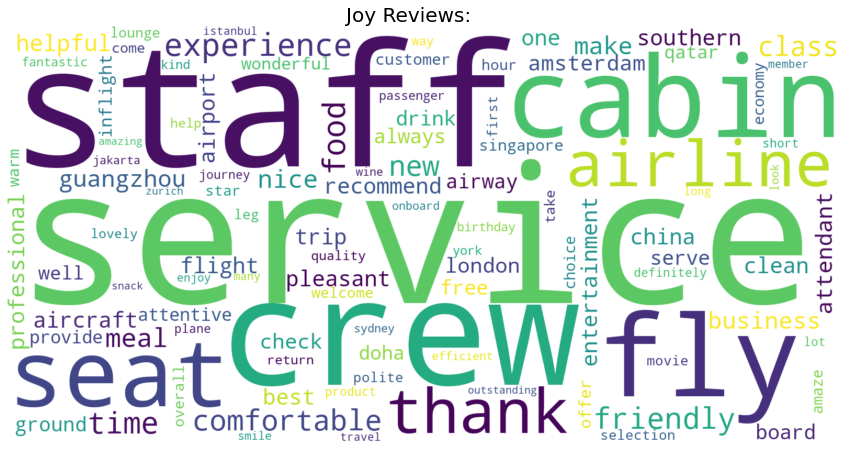

In [35]:
# Wordcoulds for Joy Reviews
wordcloud(joy_reviews,'reviews', 'white','Joy Reviews: ')

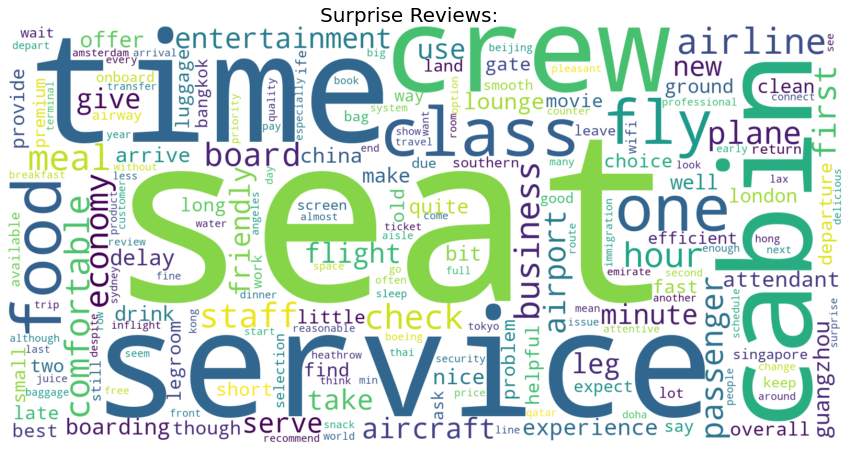

In [36]:
#Surprise
wordcloud(surprise_reviews,'reviews', 'white','Surprise Reviews: ')

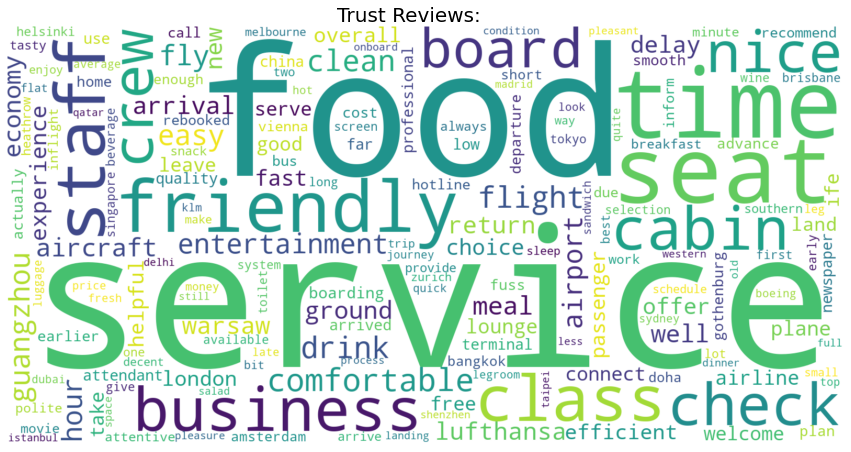

In [37]:
# Trust
wordcloud(trust_reviews,'reviews', 'white','Trust Reviews: ')

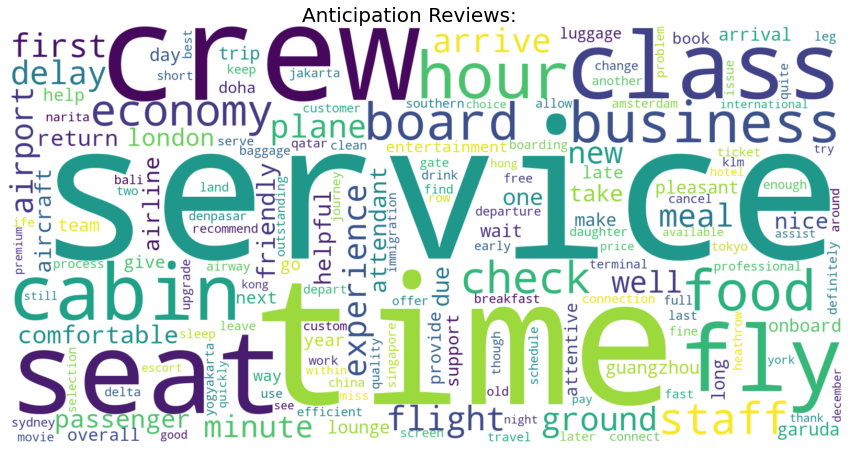

In [38]:
# Anticipation
wordcloud(anticipation_reviews,'reviews', 'white','Anticipation Reviews: ')

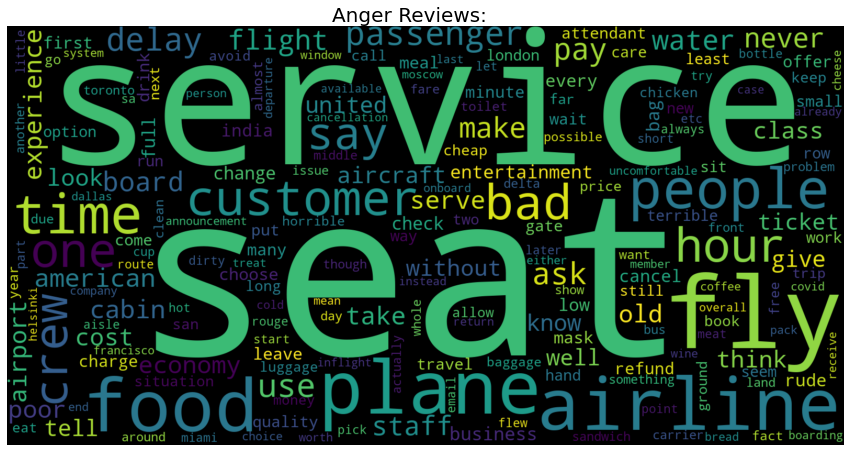

In [39]:
#anger
wordcloud(anger_reviews,'reviews', 'black','Anger Reviews: ')

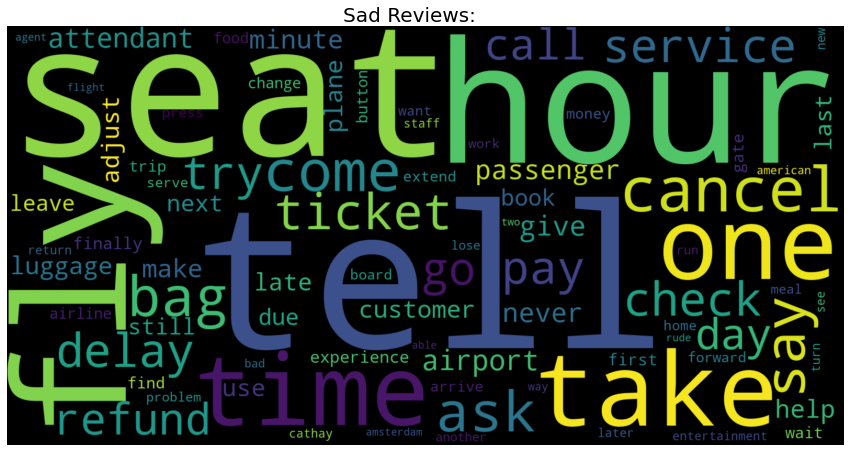

In [40]:
#sad
wordcloud(sad_reviews,'reviews', 'black','Sad Reviews: ')

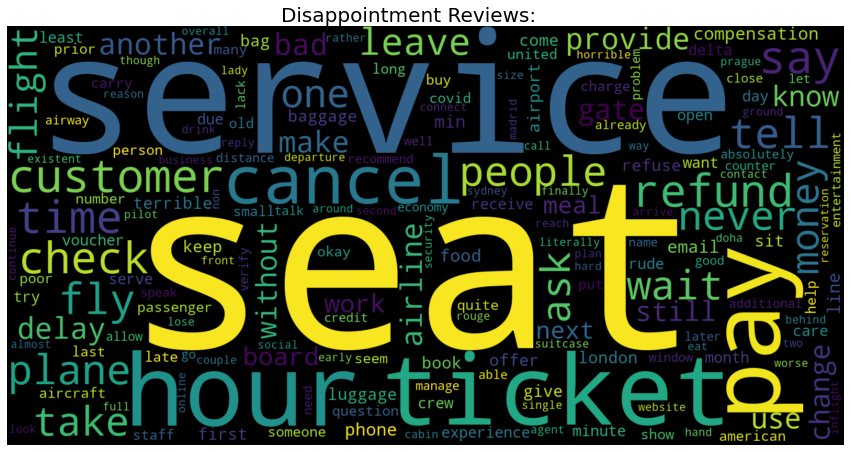

In [41]:
#disappointment
wordcloud(disappointment_reviews,'reviews', 'black', 'Disappointment Reviews: ')

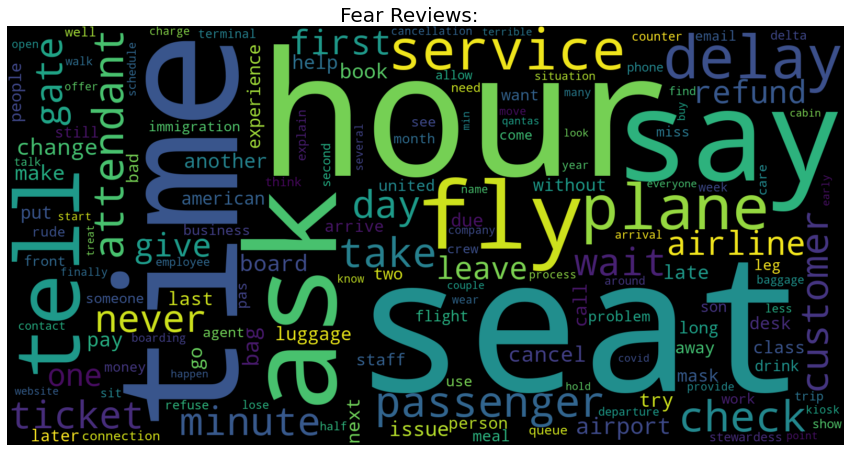

In [42]:
#fear
wordcloud(fear_reviews,'reviews', 'black', 'Fear Reviews: ')

# Part 4: Main ideas in different emotions(TFIDF)

In [64]:
import os
os.chdir("C:/Users/hyqro/Desktop/dataset")

In [5]:
# get the preprocessed reviews
pos_reviews = preprocessing('pos_reviews_s.csv')
pos_r = pd.DataFrame({"reviews":pos_reviews})
p_ratings = pd.read_csv('pos_rating.csv', names=['rating'])# positive ratings
pos_r['reviews']=[','.join(i) for i in pos_r['reviews']] 
pos_r = pd.concat([p_ratings, pos_r], axis=1)
# concat the reviews with corresponding ratings
neg_reviews = preprocessing('neg_reviews.csv')
neg_r = pd.DataFrame({"reviews":neg_reviews})
neg_r['reviews']=[','.join(i) for i in neg_r['reviews']]
n_ratings = pd.read_csv('neg_rating.csv', names=['rating'])# negative ratings
neg_r = pd.concat([n_ratings, neg_r], axis=1)

In [24]:
# extract all eight emotions into eight dataframes
result_joy = pd.read_csv('joy.csv',index_col=0)
result_joy = pd.concat([result_joy, pos_r], axis=1)
joy_reviews = result_joy[result_joy['pred'] == 1]
joy_reviews.reset_index(drop=True,inplace=True) 

result_trust = pd.read_csv('trust.csv',index_col=0)
result_trust = pd.concat([result_trust, pos_r], axis=1)
trust_reviews = result_trust[result_trust['pred'] == 1]
trust_reviews.reset_index(drop=True,inplace=True)

result_anticipation = pd.read_csv('anticipation.csv',index_col=0)
result_anticipation = pd.concat([result_anticipation, pos_r], axis=1)
anticipation_reviews = result_anticipation[result_anticipation['pred'] == 1]
anticipation_reviews.reset_index(drop=True,inplace=True) 

result_surprise = pd.read_csv('surprise.csv',index_col=0)
result_surprise = pd.concat([result_surprise, pos_r], axis=1)
surprise_reviews = result_surprise[result_surprise['pred'] == 1]
surprise_reviews.reset_index(drop=True,inplace=True) 

result_anger = pd.read_csv('anger.csv',index_col=0)
result_anger = pd.concat([result_anger, neg_r], axis=1)
anger_reviews = result_anger[result_anger['pred'] == 1]
anger_reviews.reset_index(drop=True,inplace=True) 

result_sad = pd.read_csv('sad.csv',index_col=0)
result_sad = pd.concat([result_sad, neg_r], axis=1)
sad_reviews = result_sad[result_sad['pred'] == 1]
sad_reviews.reset_index(drop=True,inplace=True) 

result_fear = pd.read_csv('fear.csv',index_col=0)
result_fear = pd.concat([result_fear, neg_r], axis=1)
fear_reviews = result_fear[result_fear['pred'] == 1]
fear_reviews.reset_index(drop=True,inplace=True) 

result_disappointment = pd.read_csv('disappointment.csv',index_col=0)
result_disappointment = pd.concat([result_disappointment, neg_r], axis=1)
disappointment_reviews = result_disappointment[result_disappointment['pred'] == 1]
disappointment_reviews.reset_index(drop=True,inplace=True) 

In [7]:
# get the customised stopwords
city_list = set([l.strip('\n').strip() for l in open('stopwords.txt','r',encoding='utf-8')])
new_stopwords = ['air','flight','extremely','airport','airline','plane','via', 'sheetal','lampung','garuda','istanbul','trips','travel',
                 'emirates','gdansk','janeiro','rio','shortest','klm','francisco','path','ife','sq','cape','mea','fly','lufthansa','airways','aircraft','flying','arrival','terminal']
city_list.update(new_stopwords)

In [8]:
# get the name of the dataframe
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [9]:
# Using a Count Vectorizer (TFIDF), I looked at the words that contributed to positive and
# negative sentiments. We plotted the top 10 words in the eight sentiments.
def show_key_words(review_name, ngram):
    '''
    input: the dataframe of each eight sentiments, figure of ngram: needs to be integers,
           
    output: Corresponding bar plot
    '''
    global city_list
    review_name['reviews'] = review_name['reviews'].apply(lambda x: ' '.join([item for item in x.split(',') if item not in city_list]))
    tfidf_n = TfidfVectorizer(ngram_range=(ngram, ngram))
    X_tfidf_n = tfidf_n.fit_transform(review_name['reviews'])
    y_n = review_name['rating']
    chi2score_n = chi2(X_tfidf_n, y_n)[0]
    scores = list(zip(tfidf_n.get_feature_names(), chi2score_n))
    chi2_n = sorted(scores, key=lambda x:x[1])
    topchi2_n = list(zip(*chi2_n[-10:]))
    x_n=range(len(topchi2_n[1]))
    fig, ax = plt.subplots(figsize=(10,7))
    ax.barh(x_n, topchi2_n[1], align='center', alpha=1, color='salmon')
    plt.title('{} Key Words'.format(get_df_name(review_name)), fontsize=22, weight='bold')# x-axis
    plt.xlabel("Feature Score", fontsize=20, weight='bold')
    plt.xticks(fontsize=12)#y-axis
    labels = topchi2_n[0]
    plt.yticks(x_n, labels, fontsize=18)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    fig = plt.gcf()
    plt.show()
    plt.draw()

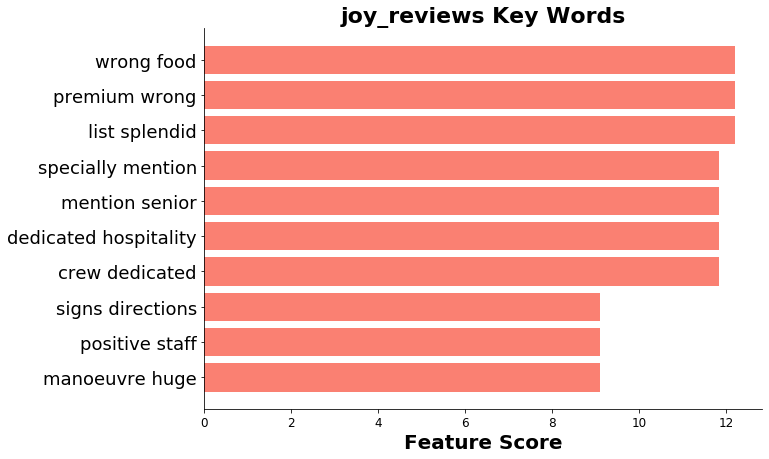

<Figure size 432x288 with 0 Axes>

In [13]:
show_key_words(joy_reviews,2)

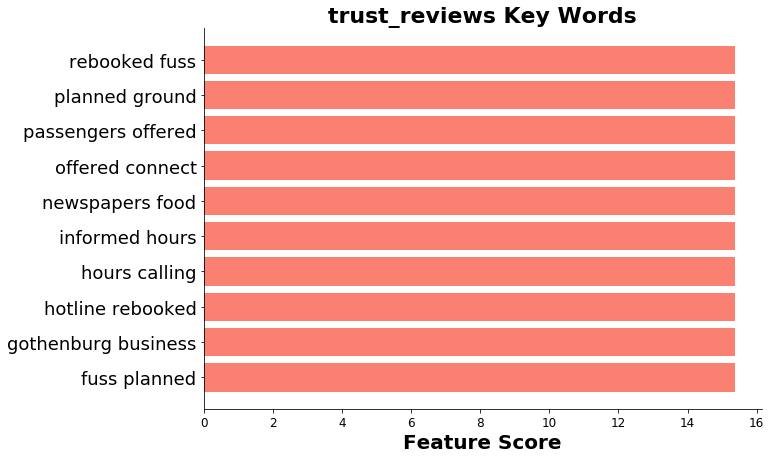

<Figure size 432x288 with 0 Axes>

In [14]:
show_key_words(trust_reviews,2)

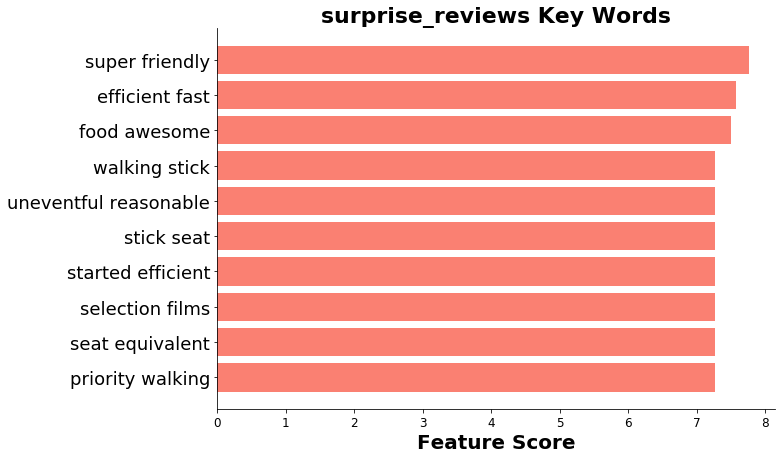

<Figure size 432x288 with 0 Axes>

In [16]:
show_key_words(surprise_reviews,2)

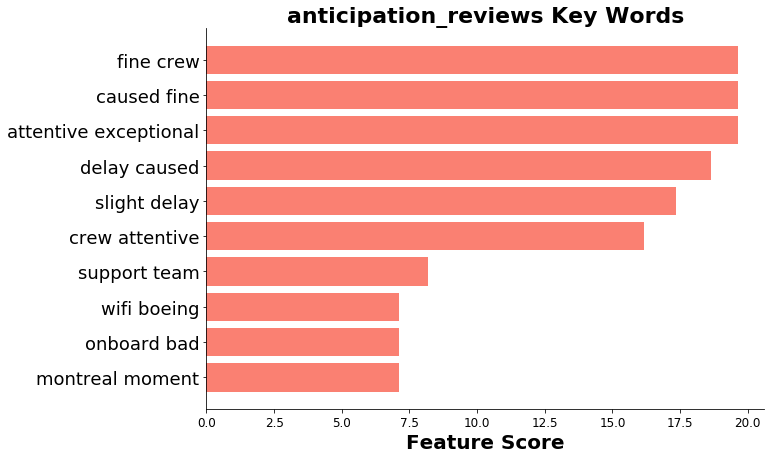

<Figure size 432x288 with 0 Axes>

In [18]:
show_key_words(anticipation_reviews,2)

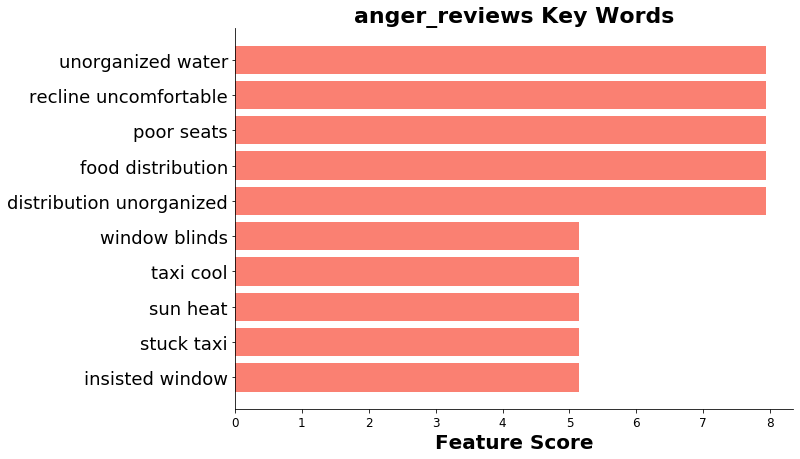

<Figure size 432x288 with 0 Axes>

In [25]:
show_key_words(anger_reviews,2)

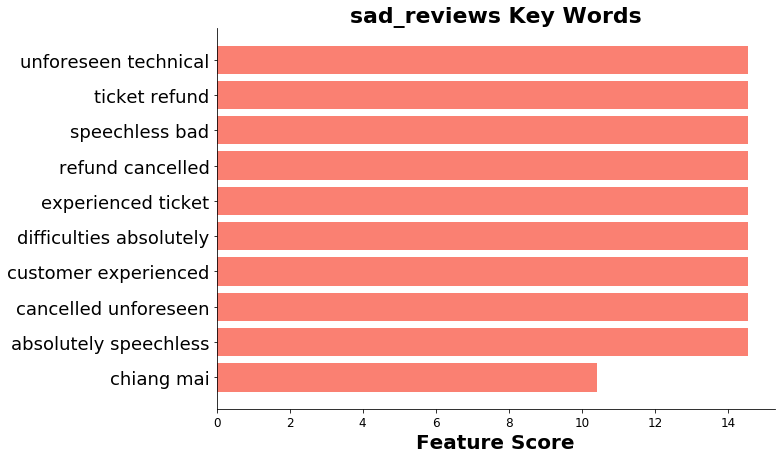

<Figure size 432x288 with 0 Axes>

In [20]:
show_key_words(sad_reviews,2)

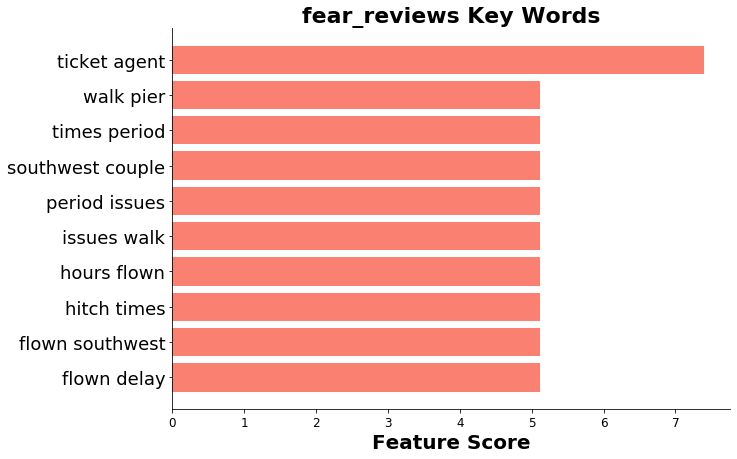

<Figure size 432x288 with 0 Axes>

In [26]:
show_key_words(fear_reviews,2)

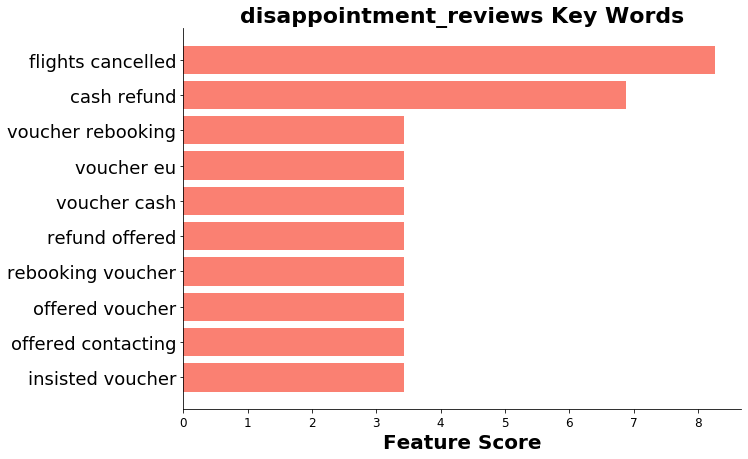

<Figure size 432x288 with 0 Axes>

In [27]:
show_key_words(disappointment_reviews,2)

### Key words extraction in reviews under two aspects of 'family' and 'covid'

In [10]:
covid_reviews = preprocessing('covid.csv')
covid_r = pd.DataFrame({"reviews":covid_reviews})
covid_ratings = pd.read_csv('covid_rating.csv', names=['rating','pred'])
covid_r['reviews']=[','.join(i) for i in covid_r['reviews']] 
covid = pd.concat([covid_ratings, covid_r], axis=1)
covid_positive = covid[covid['pred'] == 1]
covid_positive.reset_index(drop=True,inplace=True) 
covid_negative = covid[covid['pred'] == 0]
covid_negative.reset_index(drop=True,inplace=True) 

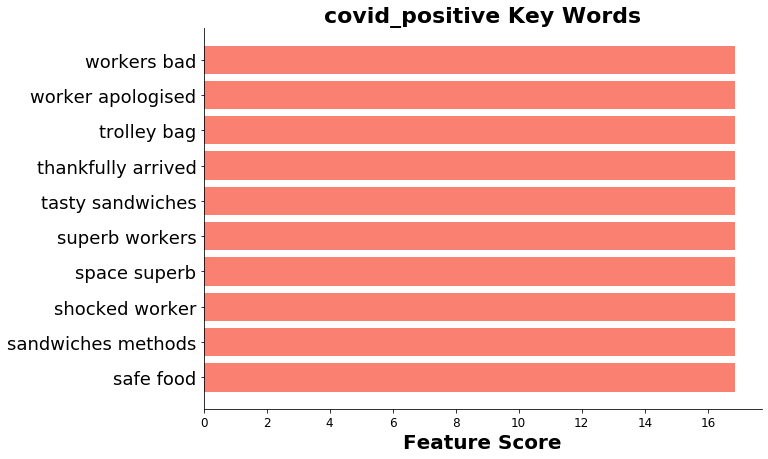

<Figure size 432x288 with 0 Axes>

In [11]:
show_key_words(covid_positive,2)

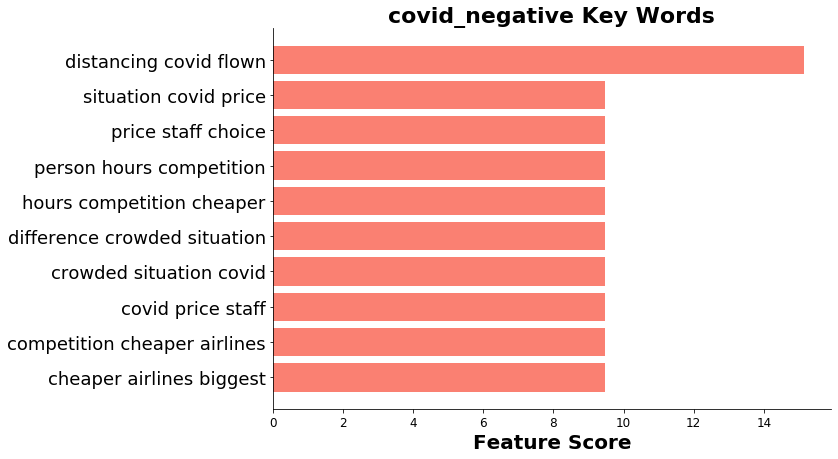

<Figure size 432x288 with 0 Axes>

In [12]:
show_key_words(covid_negative,3)

In [13]:
family_reviews = preprocessing('family.csv')
family_r = pd.DataFrame({"reviews":family_reviews})
family_ratings = pd.read_csv('family_rating.csv', names=['rating','pred'])
family_r['reviews']=[','.join(i) for i in family_r['reviews']] 
family = pd.concat([family_ratings, family_r], axis=1)
family_positive = family[family['pred'] == 1]
family_positive.reset_index(drop=True,inplace=True) 
family_negative = family[family['pred'] == 0]
family_negative.reset_index(drop=True,inplace=True) 

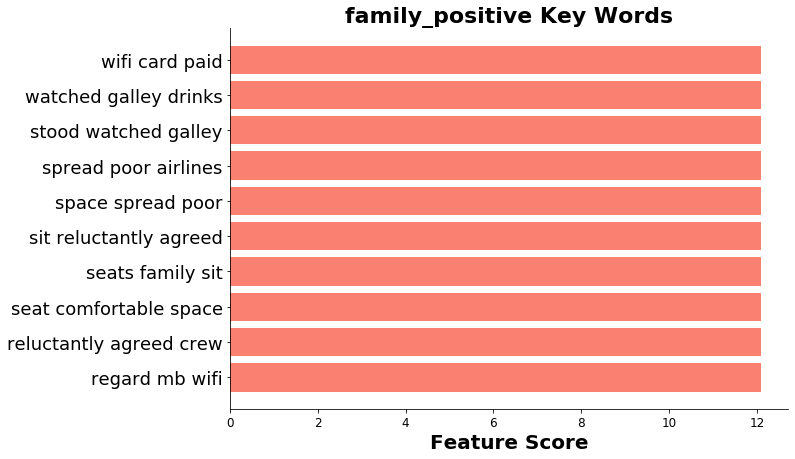

<Figure size 432x288 with 0 Axes>

In [17]:
show_key_words(family_positive,3)

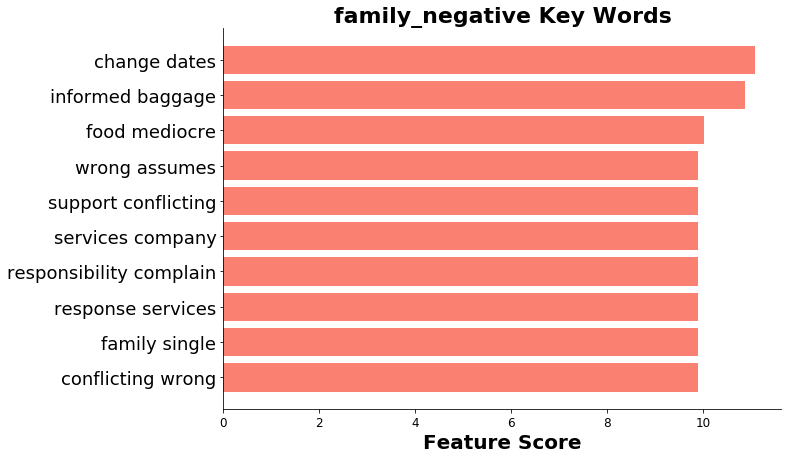

<Figure size 432x288 with 0 Axes>

In [16]:
show_key_words(family_negative,2)

# Part5:Topic discussed recently(LDA)

### the top30 frequent topics in 8 emotions

In [4]:
import os
os.chdir("C:/Users/hyqro/Desktop/dataset")

In [2]:
def Tokenizer(sent,stopwords = stopwords):
    # Tokenizer for English. 
    pat = re.compile(r'[0-9!"#$%&\'()*+,-./:;<=>?@—，。：★、￥…【】（）《》？“”‘’！\[\\\]^_`{|}~\u3000]+')
    tokens = [re.sub(pat,r'',t).strip() for t in sent.split(' ')]
    tokens = [t for t in tokens if t!='']
    from nltk.stem import WordNetLemmatizer
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(t).lower() for t in tokens]    
    tokens = [t for t in tokens if not (t in stopwords)]                                               
    
    return tokens

def corpus_dict(text):
    dictionary = Dictionary(text)
    corpus = [dictionary.doc2bow(tmp) for tmp in text]
    return dictionary, corpus

def combine(review):
    doc_com_list = []
    for i in range(len(review)):
        if i < len(review) - 1:
            doc_com = review[i] + ' ' + review[i+1]
            doc_com_list.append(doc_com)
    return doc_com_list

In [15]:
txtpath = [
    'anger_reviews.txt',
    'anticipation_reviews.txt',
    'disappointment_reviews.txt',
    'fear_reviews.txt',
    'joy_reviews.txt',
    'sad_reviews.txt',
    'surprise_reviews.txt',
    'trust_reviews.txt']

for textpath in txtpath:
    #textpath = './data/anger_reviews.txt'
    txtLines = [line.strip('\n') for line in open(textpath,encoding='utf-8') if line != []]
    stopwords = set([l.strip('\n').strip() for l in open('stopwords.txt','r',encoding='utf-8')])
    docs = [Tokenizer(txt,stopwords) for txt in txtLines]
    docs = [line for line in docs if line!=[]]
    num_topics = 1
    num_show_term = 10
    topic_word_list = []   
    for i in range(len(docs)):
        review = docs[i]
        review = combine(review)
        dictionary, corpus = corpus_dict([review])
        lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=50)
        topic_word_dict = {}   
        for topic_id in range(num_topics):
            templist = []
            term_distribute_all = lda.get_topic_terms(topicid=topic_id)
            a1 = lda.print_topics()
            term_distribute = term_distribute_all[:num_show_term]
            term_distribute = np.array(term_distribute)
            term_id = term_distribute[:, 0].astype(np.int)
            for t in term_id:
                templist.append(dictionary.id2token[t])
            topic_word_dict[topic_id] = templist
        topic_word_list.append(topic_word_dict)
        #if i%100 == 0:
        #    print(i)
    new_topic_word_list = []
    for dicti in topic_word_list:
        new_topic_word_list.append(list(dicti.values()))
    a2=[z for x in new_topic_word_list for y in x for z in y]
    from collections import Counter
    result = Counter(a2).most_common(30)
    print('The most common words in {} is \n {} \n'.format(textpath, result))

['The most common words in ./data/anger_reviews.txt is \n', " [('poor quality', 5), ('ground staff', 4), ('staff incredibly', 3), ('rude staff', 3), ('poor communication', 2), ('meal served', 2), ('los angeles', 2), ('staff rude', 2), ('notice refund', 2), ('staff extremely', 2), ('care passenger', 2), ('morning standby', 2), ('pay hotel', 2), ('offered voucher', 2), ('mind delayed', 2), ('pay seating', 2), ('booked ticket', 2), ('refund request', 2), ('refund refund', 2), ('minute serve', 2), ('scanned pas', 2), ('staff wheelchair', 2), ('delayed delayed', 2), ('refund voucher', 2), ('pillow blanket', 2), ('inflight entertainment', 2), ('travel agent', 2), ('paid extra', 2), ('sending email', 2), ('hand luggage', 2)] \n", '\n', 'The most common words in ./data/anticipation_reviews.txt is \n', " [('premium economy', 13), ('prior trip', 13), ('inflight entertainment', 12), ('lounge shower', 12), ('fare passenger', 12), ('personal attention', 12), ('personally escorted', 12), ('preparing

### covid aspect

In [18]:
stop_words=pd.read_csv('D:\\A-DSBA-YEAR2\\T2\\Hackthon\\dataset\\stop.csv')
stop_words=stop_words['0'].to_list()

In [19]:
def corpus_dict(text):
    dictionary = Dictionary(text)
    corpus = [dictionary.doc2bow(tmp) for tmp in text]
    return dictionary, corpus

In [20]:
file_path='D:\\A-DSBA-YEAR2\\T2\\Hackthon\\covid.csv'
txtLines = [line.strip('\n') for line in open(file_path,'r',encoding='utf-8')]
txtLines=[''.join(txtLines)]

In [21]:
def tokenize(corpus):
    data= re.sub(r'[,!?;-="|.]+', '',corpus)
    data= re.sub(r'[\d]','',data)

    data = nltk.word_tokenize(data)  # tokenize string to words
    data = [ ch.lower() for ch in data
             if ch.isalpha()
             or ch == '.'
             or emoji.get_emoji_regexp().search(ch)
           ]
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(t) for t in data]   
    data = [w for w in data if w not in stop_words]
    refiltered =nltk.pos_tag(data)
    filtered = [w for w, pos in refiltered if (pos.startswith('NN')or pos.startswith('J'))]
    return filtered

In [22]:
#filter some frequent words including no information
list_2=tokenize(txtLines[0])
others=['flight','flights','airline','airlines','would','via']
list_2=[x for x in list_2 if x not in others]
dictionary, corpus = corpus_dict([list_2])

In [23]:
#select 5 topic,each topic contaion 10 key words
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=30)
num_topics = 5  
num_show_term = 10
topic_word_dict = {}
for topic_id in range(num_topics):
    templist = []
    term_distribute_all = lda.get_topic_terms(topicid=topic_id)
    a1 = lda.print_topics()
    term_distribute = term_distribute_all[:num_show_term]
    term_distribute = np.array(term_distribute)
    term_id = term_distribute[:, 0].astype(np.int)
    for t in term_id:
        templist.append(dictionary.id2token[t])
    topic_word_dict[topic_id] = templist

In [16]:
#show the topic and key words regarding "covid" aspect
for i in range(5):
    print(topic_word_dict[i])

['covid', 'refund', 'due', 'service', 'time', 'customer', 'ticket', 'trip', 'passengers', 'money']
['service', 'refund', 'time', 'due', 'covid', 'ticket', 'customer', 'people', 'trip', 'travel']
['covid', 'service', 'refund', 'time', 'due', 'customer', 'ticket', 'money', 'trip', 'passengers']
['covid', 'service', 'time', 'refund', 'due', 'customer', 'ticket', 'hours', 'trip', 'money']
['service', 'refund', 'time', 'due', 'covid', 'ticket', 'customer', 'money', 'trip', 'business']


### Family aspect

In [16]:
file_path='D:\\A-DSBA-YEAR2\\T2\\Hackthon\\family.csv'

In [17]:
txtLines = [line.strip('\n') for line in open(file_path,'r',encoding='utf-8')]
txtLines=[''.join(txtLines)]

In [18]:
#filter some frequent words including no information
list_2=tokenize(txtLines[0])
others=['flight','flights','airline','airlines','would','via','service','time']
list_2=[x for x in list_2 if x not in others]
dictionary, corpus = corpus_dict([list_2])

In [19]:
#select 5 topic,each topic contaion 10 key words
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=30)

In [21]:
#show the topic and key words regarding "covid" aspect
for i in range(5):
    print(topic_word_dict[i])

['staff', 'hours', 'seats', 'seat', 'plane', 'food', 'airport', 'good', 'customer', 'air']
['seats', 'hours', 'airport', 'food', 'staff', 'seat', 'experience', 'customer', 'cabin', 'good']
['staff', 'seats', 'plane', 'air', 'seat', 'hours', 'good', 'airport', 'food', 'hour']
['hours', 'good', 'staff', 'plane', 'seats', 'seat', 'airport', 'food', 'new', 'customer']
['seat', 'airport', 'hours', 'seats', 'plane', 'good', 'food', 'staff', 'air', 'luggage']
